In [3]:
import numpy as np
import json
import matplotlib.pyplot as plt 
from scipy.spatial import Delaunay 
import skimage as sk
import scipy as sci
import cv2
import os 
from scipy.interpolate import interp2d

In [4]:
def read_pts(filename):
    return np.loadtxt(filename, comments=("version:", "n_points:", "{", "}"))

In [5]:
result = read_pts("../meanFace/points/2b.pts")

In [6]:
img = plt.imread("../meanFace/imagesSpatialNorm/2b.jpg")

<Figure size 640x480 with 0 Axes>

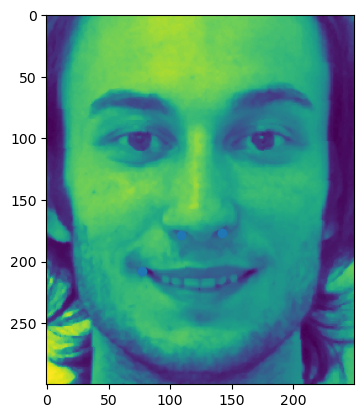

In [7]:
fig = plt.figure()
fig, ax = plt.subplots()
ax.imshow(img)

plt.plot(result[:3,0], result[:3,1], 'o')
ax.set_aspect('equal', adjustable='box')

In [8]:
avgImg = np.zeros_like(plt.imread("../meanFace/imagesSpatialNorm/2b.jpg")).astype(np.float64)
for i in range(1, 201):
    avgImg += plt.imread(f"../meanFace/imagesSpatialNorm/{i}b.jpg").astype(np.float64) * (1/200)
avgImg = avgImg/np.max(avgImg)

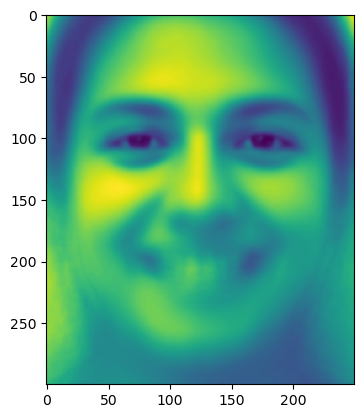

In [9]:
plt.imshow(avgImg)
plt.imsave("../meanFace/output/colorAverageFace.png", avgImg)

In [10]:
# avgPoints = np.zeros_like(read_pts("../meanFace/points/2b.pts")).astype(np.float64)
avgPoints = np.array([read_pts(f"../meanFace/points/{i}b.pts") for i in range(1, 201)])
# avgPoints = np.reshape(avgPoints, (46, 200, 2))
avgPoints.shape

(200, 46, 2)

In [11]:
avgPoints = np.array([read_pts(f"../meanFace/points/{i}b.pts") for i in range(1, 201)])
avgPoints = np.floor(np.average(avgPoints, axis=(0)))
avgPoints.shape

(46, 2)

<Figure size 640x480 with 0 Axes>

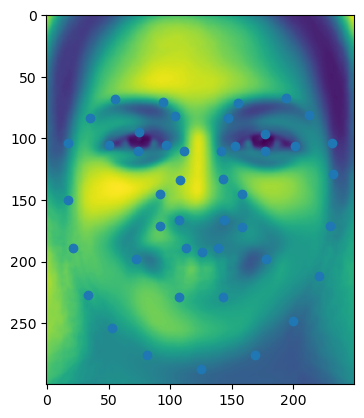

In [12]:
fig = plt.figure()
fig, ax = plt.subplots()
ax.imshow(avgImg)

plt.plot(avgPoints[:,0], avgPoints[:,1], 'o')
ax.set_aspect('equal', adjustable='box')

In [13]:
#Triangle Vert is a 3x2 array
def imgToTriangle(triangleVert, img):
    triangleVert = np.array(triangleVert)
    # centroid = np.array([np.average(triangleVert[:, 0]), np.average(triangleVert[:, 1])])
    # for idx in range(0, triangleVert.shape[0]):
    #     direction = triangleVert[idx] - centroid
    #     direction = direction/np.linalg.norm(direction)
    #     expandedVertex = triangleVert[idx] + direction * 0
    #     triangleVert[idx] = expandedVertex
    mask = sk.draw.polygon2mask(img.shape[0:3], triangleVert)
    # print(mask.shape)
    return img * mask
   #return np.stack(img[:,:,0] * mask, img[:,:,1] * mask, img[:,:,2] * mask, axis=2)

#Inverse transform from t1 to t2
def affineTrans(triIndex, t1Points, t1Simplicies, t2Points):
    t1 = [t1Points[i] for i in t1Simplicies[triIndex]]
    t2 = [t2Points[i] for i in t1Simplicies[triIndex]]
    # print(t1)
    # print(t2)
    t1Vec = np.array([t1[0] - t1[1],  t1[0] - t1[2]]).T
    t2Vec = np.array([t2[0] - t2[1],  t2[0] - t2[2]]).T
    # print(t1Vec)
    # print(t2Vec)
    t1VecToRight = np.eye(3)
    t1VecToRight[0:2, 0:2] = t1Vec
    t1VecToRight[0:2, 2] = t1[0]
    t1VecToRight = np.linalg.inv(t1VecToRight)

    rightToT2 = np.eye(3)
    rightToT2[0:2, 0:2] = t2Vec
    rightToT2[0:2, 2] = t2[0]

    return rightToT2 @ t1VecToRight
    
def warpImg(im1Points, im1Tri, im2Points, img):
    warpedIm2 = np.zeros_like(img).astype(np.float64)
    for i in range(0, len(im1Tri.simplices)):
        maskedIm2 = imgToTriangle([[im2Points[i][1],im2Points[i][0]] for i in im1Tri.simplices[i]], img)
        inverseMap = affineTrans(i, im1Points, im1Tri.simplices, im2Points)
        triangle = np.clip(sk.transform.warp(maskedIm2, inverseMap), 0, 1)
        warpedIm2 += triangle
    return warpedIm2

def warpWithRatio(im1, im1Points, im2, im2Points, crossRatio, morphRatio):
    # averageImg = np.average([im2Points[0], im2Points[0]], weights=[morphRatio, 1-morphRatio], axis=0)
    averagePoints = [np.average(a, weights=[morphRatio, 1-morphRatio], axis=0) for a in zip(im1Points, im2Points)]
    averagePoints = np.array(averagePoints) 
    triAverage = Delaunay(averagePoints)
    img1Warp = warpImg(averagePoints, triAverage, im1Points, im1)
    img2Warp = warpImg(averagePoints, triAverage, im2Points, im2)
    interpolatedImg = img1Warp * crossRatio + img2Warp * (1-crossRatio)
    interpolatedImg = np.clip(interpolatedImg, 0, 1)
    
    return interpolatedImg


In [20]:
im2 = plt.imread(f"../meanFace/imagesSpatialNorm/1b.jpg")
im2Points = read_pts("../meanFace/points/1b.pts")
avgPoints = list(avgPoints)
im2Points = list(im2Points)
avgPoints.extend([[0,im2.shape[0]], [im2.shape[1],im2.shape[0]], [0,0], [im2.shape[1],0]])
avgPoints.extend([[0,im2.shape[0]//2], [im2.shape[1],im2.shape[0]//2], [im2.shape[1]//2,im2.shape[0]], [im2.shape[1]//2,0]])
im2Points.extend([[0,im2.shape[0]], [im2.shape[1],im2.shape[0]], [0,0], [im2.shape[1],0]])
im2Points.extend([[0,im2.shape[0]//2], [im2.shape[1],im2.shape[0]//2], [im2.shape[1]//2,im2.shape[0]], [im2.shape[1]//2,0]])

avgPoints = np.array(avgPoints)
im2Points = np.array(im2Points)
triAverage = Delaunay(avgPoints)

In [21]:
warpedImg = warpImg(avgPoints, triAverage, im2Points, im2)

In [22]:
print(type(warpedImg[0,0]))
print(np.max(warpedImg))
print(np.min(warpedImg))

<class 'numpy.float64'>
0.9822261511322835
0.023529411764705896


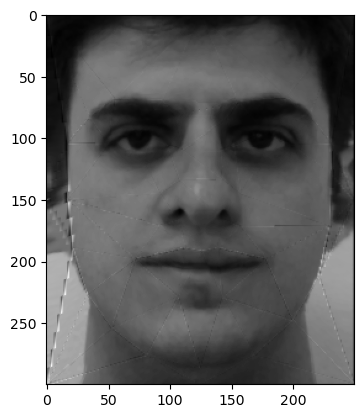

In [17]:
plt.imshow(warpedImg, cmap="grey")

<Figure size 640x480 with 0 Axes>

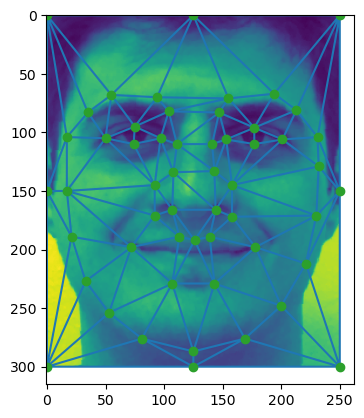

In [18]:
fig = plt.figure()
fig, ax = plt.subplots()
ax.imshow(im2)

plt.triplot(avgPoints[:,0], avgPoints[:,1], triAverage.simplices)
plt.plot(avgPoints[:,0], avgPoints[:,1], 'o')
ax.set_aspect('equal', adjustable='box')


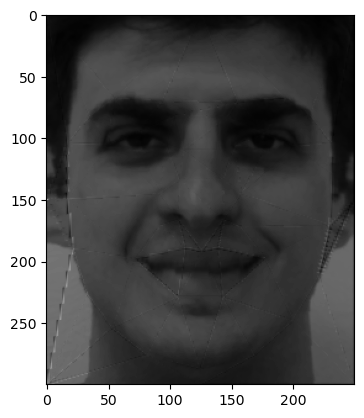

In [19]:
plt.imshow(warpedImg, cmap="grey")